In [1]:
import os, os.path
import csv
import numpy
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.snapshot import nemo_util
from galpy.df import impulse_deltav_plummer_curvedstream, \
    impulse_deltav_plummerstream_curvedstream
import seaborn as sns
import matplotlib.lines as mlines
from galpy.util import bovy_plot, bovy_coords, bovy_conversion, multi
%pylab inline
from stream2_util import rectangular_to_cylindrical, R0, V0, lp, calc_apar, calc_aA_sim
import calc_deltav
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Figure to accompany Editor's Suggestion

In [2]:
# GC
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gc_evol_unp_atimpact.dat')
snap_gc= nemo_util.read(filename,swapyz=True)
# Various DM streams
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.50_untilimpact.dat')
snap_dm0p5= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.25_untilimpact.dat')
snap_dm0p25= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.375_untilimpact.dat')
snap_dm0p375= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.125_untilimpact.dat')
snap_dm0p125= nemo_util.read(filename,swapyz=True)

In [3]:
# DM at the time of impact
xv_dm_impact= numpy.array([-13.500000,2.840000,-1.840000,6.82200571,132.7700529,149.4174464])
RvR_dm_impact= rectangular_to_cylindrical(xv_dm_impact[:,numpy.newaxis].T)[0,:]
dm_impact= Orbit([RvR_dm_impact[0]/R0,RvR_dm_impact[1]/V0,RvR_dm_impact[2]/V0,
                  RvR_dm_impact[3]/R0,RvR_dm_impact[4]/V0,RvR_dm_impact[5]],ro=R0,vo=V0)
dm_impact= dm_impact.flip()
# Integrate to 0.125 time units earlier
times= numpy.linspace(0.,0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0),1001)
dm_impact.integrate(times,lp)
dm_forward= dm_impact(times[-1]).flip()
times= numpy.linspace(0.,0.250*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0),1001)
dm_forward.integrate(times,lp)

In [4]:
# Snapshots are now combined, read various DM streams
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.50_afterimpact.dat')
snap_dm0p5_after= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.375_afterimpact.dat')
snap_dm0p375_after= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.25_afterimpact.dat')
snap_dm0p25_after= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.125_afterimpact.dat')
snap_dm0p125_after= nemo_util.read(filename,swapyz=True)

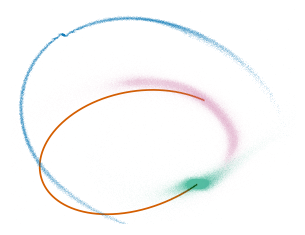

In [5]:
if save_figures:
    alpha_gc= 1.
    alpha_dm= 0.5
else:
    alpha_gc= 0.05
    alpha_dm= 0.01
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(3,3*(35./40.))
# When plotting outside the axes, need to cut everything we don't want to see
xmin, xmax= -17., 17
ymin, ymax= -10., 20
gcIndx= (snap_gc[:,1,-1] > xmin)*(snap_gc[:,1,-1] < xmax)\
    *(snap_gc[:,3,-1] > ymin)*(snap_gc[:,3,-1] < ymax)
bovy_plot.bovy_plot(snap_gc[gcIndx,1,-1],snap_gc[gcIndx,3,-1],',',alpha=alpha_gc,
                    color=sns.color_palette("colorblind")[0],zorder=3,
                    xrange=[-10.,10.],yrange=[-5.,15],rasterized=True,
                    gcf=True,clip_on=False)
dmIndx= (snap_dm0p25[:,1,-1] > xmin)*(snap_dm0p25[:,1,-1] < xmax)\
    *(snap_dm0p25[:,3,-1] > ymin)*(snap_dm0p25[:,3,-1] < ymax)
plot(snap_dm0p25[dmIndx,1,-1],snap_dm0p25[dmIndx,3,-1],',',alpha=alpha_dm,color=sns.color_palette("colorblind")[1],
     rasterized=True,zorder=5,clip_on=False)
dmIndx= (snap_dm0p25_after[100000:,1,-1] > xmin)*(snap_dm0p25_after[100000:,1,-1] < xmax)\
    *(snap_dm0p25_after[100000:,3,-1] > ymin)*(snap_dm0p25_after[100000:,3,-1] < ymax)
plot(snap_dm0p25_after[100000:,1,-1][dmIndx],snap_dm0p25_after[100000:,3,-1][dmIndx],
     ',',rasterized=True,alpha=alpha_dm,color=sns.color_palette("colorblind")[3],zorder=4,clip_on=False)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette("colorblind")[2],zorder=2,
               clip_on=False)# Label GC stream
pyplot.axis('off')
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2015-stream-stream','fig4editorssuggestion.pdf'),
                            dpi=400,bbox_inches='tight')